<a href="https://colab.research.google.com/github/krmonline/AnomalyDetection/blob/master/LSTM_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import numpy as np
import tensorflow as tf
#from keras.models import Sequential, Model
#from keras.layers import LSTM  ,RepeatVector ,TimeDistributed , Dense ,  GRU
#from keras.utils import plot_model
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error

In [15]:
df = pd.read_csv('https://raw.githubusercontent.com/krmonline/AnomalyDetection/master/data/timeseries1.csv',names=['eps'])
len(df.eps)
series = df.eps.values

In [16]:
from sklearn.preprocessing import minmax_scale

In [64]:
#Prepare
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        #print("end_ix="+str(end_ix))
        if end_ix > len(sequence)-1:
            break
        seq_x = [tmp for tmp in sequence[i:end_ix]]
        X.append(seq_x)
    return np.array(X)

seq_step  = 5

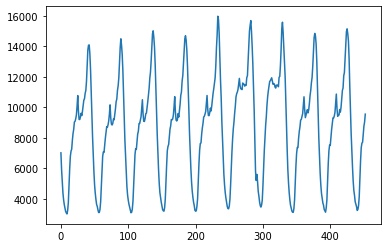

In [4]:
plt.plot(df)

In [69]:
series_scale = minmax_scale(df.eps.values)

In [70]:
train_set = split_sequence(series_scale,seq_step)
display(train_set)
train_set.shape

array([[0.30888917, 0.22337158, 0.15989846, 0.10580678, 0.07112628],
       [0.22337158, 0.15989846, 0.10580678, 0.07112628, 0.04697813],
       [0.15989846, 0.10580678, 0.07112628, 0.04697813, 0.03079996],
       ...,
       [0.26946399, 0.3355303 , 0.35786307, 0.36261931, 0.40318306],
       [0.3355303 , 0.35786307, 0.36261931, 0.40318306, 0.44503878],
       [0.35786307, 0.36261931, 0.40318306, 0.44503878, 0.46533183]])

(448, 5)

In [71]:
sequence = train_set.reshape(train_set.shape[0],seq_step,-1)
sequence.shape

(448, 5, 1)

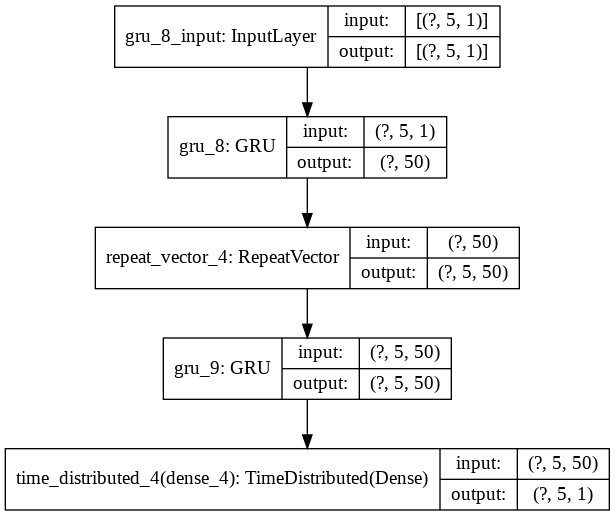

In [76]:
# define model
history=[]
model = Sequential()
model.add(GRU(50, activation='relu', input_shape=(seq_step,1)))
model.add(RepeatVector(seq_step))
model.add(GRU(50, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')
plot_model(model, show_shapes=True, to_file='reconstruct_lstm_autoencoder.png')

In [77]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_8 (GRU)                  (None, 50)                7950      
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 5, 50)             0         
_________________________________________________________________
gru_9 (GRU)                  (None, 5, 50)             15300     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 5, 1)              51        
Total params: 23,301
Trainable params: 23,301
Non-trainable params: 0
_________________________________________________________________


In [117]:
history_tmp=model.fit(sequence, sequence, epochs=1000, verbose=1)
history.extend(history_tmp.history['loss'])

Epoch 1/1000
14/14 [==============================] - 0s 7ms/step - loss: 4.1856e-05
Epoch 2/1000
14/14 [==============================] - 0s 7ms/step - loss: 5.1984e-05
Epoch 3/1000
14/14 [==============================] - 0s 7ms/step - loss: 5.0107e-05
Epoch 4/1000
14/14 [==============================] - 0s 8ms/step - loss: 4.8175e-05
Epoch 5/1000
14/14 [==============================] - 0s 7ms/step - loss: 4.3399e-05
Epoch 6/1000
14/14 [==============================] - 0s 7ms/step - loss: 4.3607e-05
Epoch 7/1000
14/14 [==============================] - 0s 7ms/step - loss: 4.4735e-05
Epoch 8/1000
14/14 [==============================] - 0s 7ms/step - loss: 4.5972e-05
Epoch 9/1000
14/14 [==============================] - 0s 7ms/step - loss: 4.5285e-05
Epoch 10/1000
14/14 [==============================] - 0s 7ms/step - loss: 4.3460e-05
Epoch 11/1000
14/14 [==============================] - 0s 7ms/step - loss: 4.5169e-05
Epoch 12/1000
14/14 [==============================] - 0s 7ms/s

#Train ที่ 100 epochs ได้ค่า MSE อยู่ที่ ~ 10

3.0963456083554775e-05


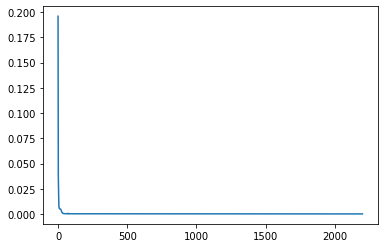

In [118]:
plt.plot(history)
print(history[-1])

In [ ]:
model.save("lstm_autoencoder.f5")
model.save_weights("lstm_autoencoder_weight.f5")

In [ ]:
model.load_weights('lstm_autoencoder_weight.f5')

In [119]:
test = sequence[119].copy()
test = test.reshape(1,5,1)
print(test.shape)
print(test)

(1, 5, 1)
[[[0.49159833]
  [0.53653058]
  [0.57764627]
  [0.50649301]
  [0.4686905 ]]]


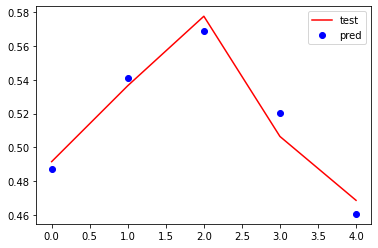

In [120]:
pred = model.predict([test])
pred2 = pred.reshape(5,1)

plt.plot(test.reshape(5,1),'r-')

plt.plot(pred2.reshape(5,1),'bo')
plt.legend(['test','pred'])

# เมื่อนำ Data Test และ Pred มาเทียบกันพบว่าใกล้เคียงกัน

In [121]:
diff = test - pred
print(abs(diff))
print(mean_squared_error(test.reshape(5,1), pred.reshape(5,1)))

[[[0.00421699]
  [0.00428495]
  [0.00883747]
  [0.01403787]
  [0.0080459 ]]]
7.520862464080066e-05


#แก้จุดที่ 2 ให้สูงผิดปรกติ (Anomaly)

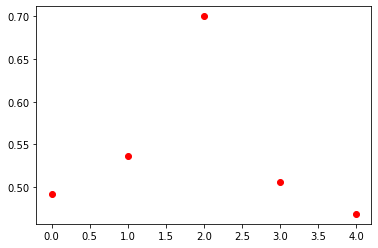

In [124]:
test[0][2][0] = 0.7
plt.plot(test.reshape(5,1),'ro')

#ผลที่ได้คือ Predict ออกมาไม่เหมือนกันกับ Data ที่นำเข้าเนื่องจากเราสร้าง anomaly ขึ้นมาเอง Model ไม่เคยเห็นมาก่อน และ MSE มีค่าสูง 

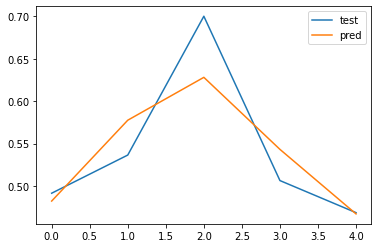

In [125]:
pred = model.predict([test])
pred = pred.reshape(5,1)
plt.plot(test.reshape(5,1))
plt.plot(pred)
plt.legend(['test','pred'])

In [126]:
diff = test - pred
print(abs(diff))
print(mean_squared_error(test.reshape(5,1), pred.reshape(5,1)))

[[[0.00923785]
  [0.04103652]
  [0.0719461 ]
  [0.03673622]
  [0.00147144]]]
0.0016594579072009368


# TEST

#เราสร้างจุดที่เป็น Anomaly ขึ้นมา ให้เกิดความผิดปรกติขึ้นและนำ Data เข้าไปใน Model

In [136]:
df = pd.read_csv('https://raw.githubusercontent.com/krmonline/AnomalyDetection/master/data/timeseries4.csv',names=['eps'])
data1 = df['eps'].values[:]
data1 = np.asarray(data1)
#data1[180] =  20000
data1[90] = 10000
data1[10] = 12000
data1[50] = 7000
data1[150] = 7000

In [137]:
data1 = minmax_scale(data1)
test_set = split_sequence(data1,seq_step)
display(test_set[-1])
test_set.shape

array([0.35418694, 0.36108571, 0.40501596, 0.44765987, 0.47150164])

(448, 5)

In [138]:
mseval = []
for i in test_set:
    test = i.reshape(1,5,1)
    pred = model.predict([test])
    mse = mean_squared_error(test.reshape(5,1),pred.reshape(5,1))
    mseval.append(mse)

#ตั้ง Threshold ให้กับค่า MSE

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


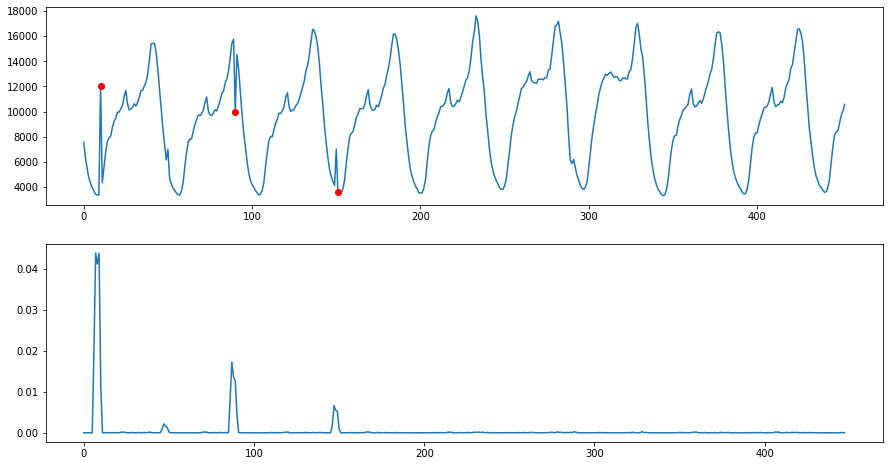

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

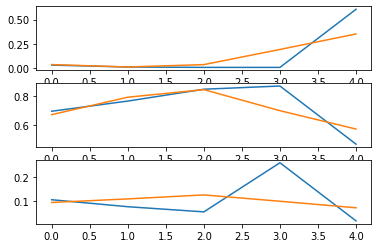

In [142]:
plt.figure(figsize=(15, 8))
anomaly = False
anomaly_pos2 = []
anomaly_pos = 0
threshold = 0.005
plt.subplot(211).plot(df.eps.values)
for i in range(len(mseval)):
    if mseval[i]  > threshold:
        anomaly = True
        if anomaly_pos < mseval[i]:
            anomaly_pos = i
    elif mseval[i]  < threshold and anomaly == True:
        #Reset Anomaly
        plt.subplot(211).plot(anomaly_pos+4,df.eps.values[anomaly_pos+4],'ro')
        anomaly = False
        anomaly_pos2.append(anomaly_pos)
        anomaly_pos = 0
        #display(test_set[anomaly_pos])
plt.subplot(212).plot(mseval)
plt.show()
c = len(anomaly_pos2)
#print(c)
#print(anomaly_pos2)
for i in range(c):
    pos = anomaly_pos2[i]
    #print(i,pos)
    plt.subplot(c,1,i+1).plot(test_set[pos])
    pred = model.predict(test_set[pos].reshape(1,5,1))
    plt.subplot(c,1,i+1).plot(pred.reshape(5,1))
    diff = test_set[pos] - pred
    #print(test_set[pos],pred.reshape(1,5),diff,mseval[pos])